<a href="https://colab.research.google.com/github/jainmridul82/Neural-Networks/blob/main/Data_Augmentation%2C_Regularization%2C_and_ResNets_%7C_Deep_Learning_with_PyTorch_Zero_to_GANs_%7C_5_of_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import os
import torch
import torchvision
import matplotlib
import matplotlib.pyplot as plt
import tarfile

In [ ]:
matplotlib.rcParams['figure.facecolor']='white'
%matplotlib inline

In [ ]:
url="https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
torchvision.datasets.utils.download_url(url,".")

In [ ]:
with tarfile.open("/content/cifar10.tgz","r:gz") as tar:
    tar.extractall("./data")

In [ ]:
data_dir="/content/data/cifar10"
print(os.listdir(data_dir))

['train', 'test']


In [ ]:
print(os.listdir(data_dir+"/train"))

['truck', 'airplane', 'cat', 'deer', 'horse', 'automobile', 'dog', 'frog', 'ship', 'bird']


In [ ]:
stats=((0.4914,0.4822,0.4465),(0.2023,0.1994,0.2010))
train_transform=torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(32,padding=4,padding_mode='reflect'),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(*stats,inplace=True)
])
test_transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(*stats)
])

In [ ]:
train_ds=torchvision.datasets.ImageFolder(data_dir+"/train",transform=train_transform)
test_ds=torchvision.datasets.ImageFolder(data_dir+"/test",transform=test_transform)

In [ ]:
batch_size=128
train_dataloader=torch.utils.data.DataLoader(train_ds,batch_size,shuffle=True,pin_memory=True,num_workers=3)
test_dataloader=torch.utils.data.DataLoader(test_ds,batch_size,pin_memory=True,num_workers=3)

In [ ]:
def denormalize(images,means,stds):
    means=torch.tensor(means).reshape(1,3,1,1)
    stds=torch.tensor(stds).reshape(1,3,1,1)
    return images*stds+means

In [ ]:
def show_batch(dl):
    for images,_ in dl:
        fig,ax=plt.subplots(figsize=(12,12))
        ax.set_xticks([])
        ax.set_yticks([])
        denorm_images=denormalize(images,*stats)
        X=torchvision.utils.make_grid(denorm_images,nrow=8)
        ax.imshow(X.permute(1,2,0).clamp(0,1))
        break

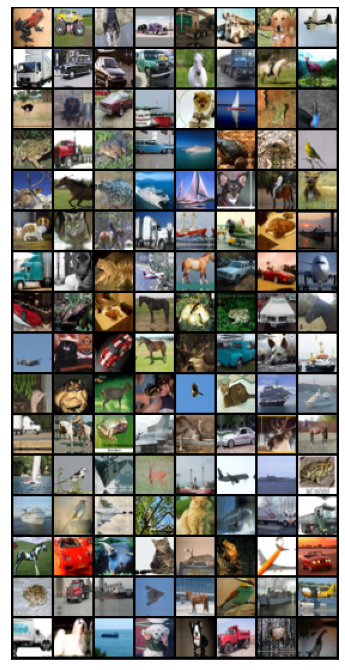

In [ ]:
show_batch(train_dataloader)

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")

In [ ]:
device=get_default_device()

In [ ]:
print(device)

cuda


In [ ]:
def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

In [ ]:
class DataLoader:
    def __init__(self,data,device):
        self.data=data
        self.device=device
    def __len__(self):
        return len(self.data)
    def __iter__(self):
        for x in self.data:
            yield to_device(x,self.device)

In [ ]:
train_loader=DataLoader(train_dataloader,device)
test_loader=DataLoader(test_dataloader,device)

In [ ]:
class SimpleResidualNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.network=torch.nn.Sequential(
            torch.nn.Conv2d(3,3,kernel_size=3,padding=1,stride=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(3,3,kernel_size=3,padding=1,stride=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(3,3,kernel_size=3,padding=1,stride=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(3,3,kernel_size=3,padding=1,stride=1),
            torch.nn.ReLU()
        )
    def forward(self,X):
        out=self.network(X)
        return out+X

In [ ]:
model=to_device(SimpleResidualNetwork(),device)
for images,_ in train_loader:
    out=model(images)
    print(out.shape)
    break
torch.cuda.empty_cache()

torch.Size([128, 3, 32, 32])


In [ ]:
del model,images,out

In [ ]:
def accuracy(pred,labels):
    _,labelp=torch.max(pred,dim=1)
    return torch.tensor(torch.sum(labelp==labels).item()/len(labels))

In [ ]:
class ImageClassificationBase(torch.nn.Module):
    def training_step(self,batch):
        images,labels=batch
        out=self(images)
        loss=torch.nn.functional.cross_entropy(out,labels)
        return loss
    def validation_step(self,batch):
        images,labels=batch
        out=self(images)
        loss=torch.nn.functional.cross_entropy(out,labels)
        acc=accuracy(out,labels)
        return {"val_acc":acc,"val_loss":loss.detach()}
    def validation_epoch_step(self,result):
        loss_=[X["val_loss"] for X in result]
        loss_=torch.stack(loss_).mean()
        acc_=[X["val_acc"] for X in result]
        acc_=torch.stack(acc_).mean()
        return {"val_acc":acc_.item(),"val_loss":loss_.item()}
    def epoch_end(self,epoch,result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch,result['lrs'][-1],
                result["train_loss"],result["val_loss"],result["val_acc"]))

In [ ]:
def conv_block(in_channels,out_channels,pool=False):
    layers=[torch.nn.Conv2d(in_channels,out_channels,3,padding=1,stride=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True)]
    if pool:
        layers.append(torch.nn.MaxPool2d(2))
    return torch.nn.Sequential(*layers)

In [ ]:
class Resnet9(ImageClassificationBase):
    def __init__(self,in_channels,num_classes):
        super().__init__()
        self.conv1=conv_block(in_channels,64) # (64,32,32)
        self.conv2=conv_block(64,128,pool=True) # (128,16,16)
        self.res1=torch.nn.Sequential(conv_block(128,128),
                                      conv_block(128,128)) # (128,16,16)
        self.conv3=conv_block(128,256,pool=True) # (256,8,8)
        self.conv4=conv_block(256,512,pool=True) # (512,4,4)
        self.res2=torch.nn.Sequential(conv_block(512,512),
                                      conv_block(512,512)) # (512,4,4)
        self.classifier=torch.nn.Sequential(torch.nn.MaxPool2d(4), # (512,1,1)
                                      torch.nn.Flatten(), # (512)
                                      torch.nn.Dropout(0.1),
                                      torch.nn.Linear(512,num_classes)) # (512,10)
    def forward(self,X):
        out=self.conv1(X)
        out=self.conv2(out)
        out=self.res1(out)+out
        out=self.conv3(out)
        out=self.conv4(out)
        out=self.res2(out)+out
        out=self.classifier(out)
        return out

In [ ]:
model=to_device(Resnet9(3,10),device)
model

Resnet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
@torch.no_grad()
def evaluate(model,val_dataloader):
    model.eval()
    result=[model.validation_step(batch) for batch in val_dataloader]
    return model.validation_epoch_step(result)

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

In [ ]:
def fit(epochs,max_lr,model,train_loader,val_loader,weight_decay=0,grad_clip=None,opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history=[]
    optimizer=opt_func(model.parameters(),max_lr,weight_decay=weight_decay)
    sched=torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr,epochs=epochs,steps_per_epoch=len(train_loader))
    for epoch in range(epochs):
        model.train()
        train_losses=[]
        lrs=[]
        for batch in train_loader:
            loss=model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            if grad_clip:
                torch.nn.utils.clip_grad_value_(model.parameters(),grad_clip)
            optimizer.step()
            optimizer.zero_grad()
            lrs.append(get_lr(optimizer))
            sched.step()
        result=evaluate(model,val_loader)
        result["train_loss"]=torch.stack(train_losses).mean().item()
        result["lrs"]=lrs
        model.epoch_end(epoch,result)
        history.append(result)
    return history

In [ ]:
history=[evaluate(model,test_loader)]

In [ ]:
print(history)

[{'val_acc': 0.09068433195352554, 'val_loss': 2.303107976913452}]


In [ ]:
epochs=30
max_lr=0.01
grad_clip=0.1
weight_decay=1e-4
opt_func=torch.optim.Adam

In [ ]:
%%time
history+=fit(epochs,max_lr,model,train_loader,test_loader,weight_decay,grad_clip,opt_func)

Epoch [0], last_lr: 0.00069, train_loss: 1.2859, val_loss: 1.1011, val_acc: 0.6072
Epoch [1], last_lr: 0.00152, train_loss: 0.8756, val_loss: 1.1396, val_acc: 0.6429
Epoch [2], last_lr: 0.00280, train_loss: 0.7883, val_loss: 0.9213, val_acc: 0.7031
Epoch [3], last_lr: 0.00436, train_loss: 0.7266, val_loss: 1.5677, val_acc: 0.6017
Epoch [4], last_lr: 0.00603, train_loss: 0.6814, val_loss: 0.7590, val_acc: 0.7472
Epoch [5], last_lr: 0.00760, train_loss: 0.6137, val_loss: 0.6092, val_acc: 0.7920
Epoch [6], last_lr: 0.00888, train_loss: 0.5881, val_loss: 0.7308, val_acc: 0.7656
Epoch [7], last_lr: 0.00971, train_loss: 0.5975, val_loss: 0.7278, val_acc: 0.7479
Epoch [8], last_lr: 0.01000, train_loss: 0.5875, val_loss: 0.6630, val_acc: 0.7647
Epoch [9], last_lr: 0.00994, train_loss: 0.5841, val_loss: 0.6608, val_acc: 0.7762
Epoch [10], last_lr: 0.00978, train_loss: 0.5832, val_loss: 0.6613, val_acc: 0.7748
Epoch [11], last_lr: 0.00950, train_loss: 0.5874, val_loss: 0.6310, val_acc: 0.7831
Ep

In [ ]:
evaluate(model,test_loader)

{'val_acc': 0.9170292615890503, 'val_loss': 0.25743985176086426}

In [ ]:
print(history[0])

{'val_acc': 0.09068433195352554, 'val_loss': 2.303107976913452}


In [ ]:
def plot_accuracies(result):
    acc=[X["val_acc"] for X in result]
    plt.plot(acc,"-bx")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()

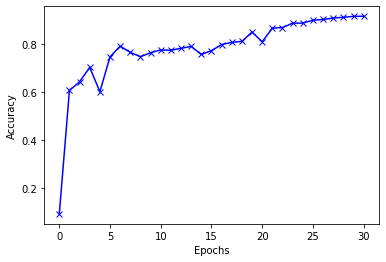

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(result):
    train_loss=[X.get("train_loss") for X in result]
    test_loss=[X.get("val_loss") for X in result]
    plt.plot(train_loss,"-bx")
    plt.plot(test_loss,"-rx")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss vs Epoch")
    plt.legend(['Training Loss','Testing Loss'])
    plt.show()

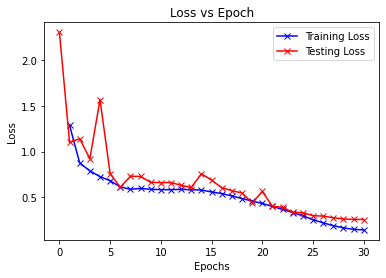

In [ ]:
plot_losses(history)

In [ ]:
def plot_lr(result):
    lrs=np.concatenate([x.get("lrs",[]) for x in result])
    plt.plot(lrs)
    plt.xlabel("Batches")
    plt.ylabel("LR")
    plt.title("LR vs Batches")
    plt.show()

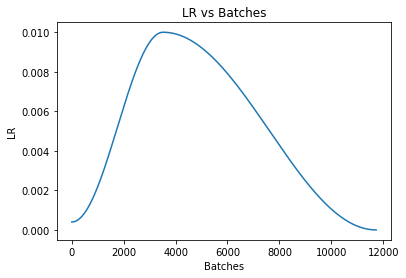

In [ ]:
plot_lr(history)

In [ ]:
def predict_img(img,model):
    img_=to_device(img.unsqueeze(0),device)
    out=model(img_)
    _,predl=torch.max(out,dim=1)
    return train_ds.classes[predl[0].item()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: frog, Predicted Label: frog


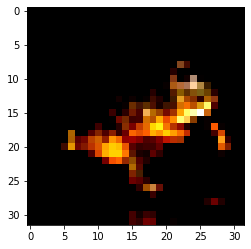

In [ ]:
img,label=test_ds[6153]
plt.imshow(img.permute(1,2,0))
y=predict_img(img,model)
print("Label: {}, Predicted Label: {}".format(test_ds.classes[label],y))

In [ ]:
torch.save(model.state_dict(),"first.pth")